In [95]:
# Initialize Otter
import otter
grader = otter.Notebook("ProjPart2.ipynb")

# Project - Part 2 (updated 11/25/24 at 8pm): 

## Predicting Housing Prices in Cook County

## Due Date: Thursday, Dec 5th, 11:59 PM MT on Gradescope

## NO LATE SUBMISSIONS will be accepted - you must plan accordingly.

## Collaboration Policy

Data science is a collaborative activity.  However a key step in learning and retention is **creating solutions on your own.**  

Below are examples of acceptable vs unacceptable use of resources and collaboration when doing the Project assignments in CSCI 3022.


The following would be some **examples of cheating** when working on the Project in CSCI 3022.  Any of these constitute a **violation of the course's collaboration policy and will result in an F in the course and a trip to the honor council**.   


 - Consulting web pages that may have a solution to a given homework problem or one similar is cheating.  However, consulting the class notes, and web pages that explain the material taught in class but do NOT show a solution to the homework problem in question are permissible to view.  Clearly, there's a fuzzy line here between a valid use of resources and cheating. To avoid this line, one should merely consult the course notes, the course textbook, and references that contain syntax and/or formulas.
 - Copying a segment of code or math solution of three lines or more from another student from a printout, handwritten copy, or by looking at their computer screen 
 - Allowing another student to copy a segment of your code or math solution of three lines or more
 - Taking a copy of another student's work (or a solution found online) and then editing that copy
 - Reading someone else’s solution to a problem on the Project before writing your own.
 - Asking someone to write all or part of a program or solution for you.
 - Asking someone else for the code necessary to fix the error for you, other than for simple syntactical errors
 


On the other hand, the following are some **examples of things which would NOT usually be
considered to be cheating**:
 - Working on a Project problem on your own first and then discussing with a classmate a particular part in the problem solution where you are stuck.  After clarifying any questions you should then continue to write your solution independently.
 - Asking someone (or searching online) how a particular construct in the language works.
 - Asking someone (or searching online) how to formulate a particular construct in the language.
 - Asking someone for help in finding an error in your program.  
 - Asking someone why a particular construct does not work as you expected in a given program.
   

To test whether you are truly doing your own work and retaining what you've learned you should be able to easily reproduce from scratch and explain a Project solution that was your own when asked in office hours by a TA/Instructor or on a quiz/exam.   


If you have difficulty in formulating the general solution to a problem on your own, or
you have difficulty in translating that general solution into a program, it is advisable to see
your instructor or teaching assistant rather than another student as this situation can easily
lead to a, possibly inadvertent, cheating situation.

We are here to help!  Visit HW Hours and/or post questions on Piazza!


## Introduction

In Part 1 of this project, you performed some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions. Then, you added a few new features to the dataset, cleaning the data as well in the process.

In Part 2 of the project, you will specify and fit a linear model to a few features of the housing data to predict housing prices. Next, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this assignment - and think about what fairness might mean to property owners in Cook County.

After this part of the project, you should be comfortable with:
- Implementing a data processing pipeline using `pandas`
- Using `scikit-learn` to build and fit linear models

## Score Breakdown

Question | Manual | Points
----|----|----
1abd | Yes | 5
1c | No | 1
2acd | No| 4
2b | Yes | 3
3 | No | 2
4 | No | 10
5 | No | 7
6 | Combo | 14
7 | Yes | 4
Total | | 50 | 32
Extra Credit| Yes| Up to +20

In [96]:
import hashlib

import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

def get_hash(num):
    return hashlib.md5(str(num).encode()).hexdigest()

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training and test data.

In [97]:
# RUN THIS  - DON'T COMMENT THIS OUT - it is needed for the autograder.

with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

This dataset is split into a training/validation set, and a test set. Importantly, the test set does not contain values for our target variable, Sale Price. In this project, you will train a model on the training and validation sets and then use this model to predict the Sale Prices of the test set. In the cell below, we load the training and validation sets into the DataFrame `tr_val_data` and the test set into the DataFrame `test_data`.

In [98]:
tr_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

In [99]:
len(test_data)

55311

As a good sanity check, we should at least verify that the data shape matches the description.

In [100]:
# 204792 observations and 62 features in training data
assert tr_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in tr_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Let's remind ourselves of the data available to us in the Cook County dataset. Remember, a more detailed description of each variable is included in `codebook.txt`, which is in the same directory as this notebook). **If you did not attempt Project Part 1,** you should take some time to familiarize yourself with the codebook before moving forward.

In [101]:
tr_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 1: Human Context and Ethics

In this part of the project, we will explore the human context of our housing dataset.

**You should read the [Project_CaseStudy.pdf](https://canvas.colorado.edu/courses/109109/modules/items/5659390) on Canvas explaining the context and history surrounding this dataset before attempting this section.**

<br>

--- 

<!-- BEGIN QUESTION -->

### Question 1a
In this project we are essentially trying to answer the question.  "How much is a house worth?" 
 - Who might be interested in an answer to this question? **Please list at least three different parties (people or organizations) and then describe whether each one has an interest in seeing the housing price to be either high or low.**

Parties that may be interested in trying to answer this question are: real estate agents, homeowners, and prospective home buyers. Real estate agents would be interested in seeing and keeping track of housing prices in order to determine when to sell to clients. When housing prices are higher, agents are able to sell for a higher profit which allows them to receive a higher commission. As for homeowners, if they want to sell their existing home, they would seek to sell when housing prices are higher to earn a profit. On the contrary, home buyers would look to purchase when housing prices are low since they're more affordable and likely have lower interest rates as well.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1b

 - 1bi).  Which of the following scenarios strike you as unfair and why? You can choose more than one. There is no single right answer, but you must explain your reasoning.
 - 1bii). Would you consider some of these scenarios more (or less) fair than others? Why?

Scenario A: A homeowner whose home is assessed at a higher price than it would sell for.  
Scenario B: A homeowner whose home is assessed at a lower price than it would sell for.  
Scenario C: An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
Scenario D: An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.


Write your full answers to both parts in the cell below:

All of these scenarios are seemingly unfair due to the fact that they either over or undervalue some aspect of each property. Scenario C is the most unfair due to its systematic bias against lower-value property owners since it places a greater burden on those who are less able to bear it, while Scenario A is also concerning for the financial burden it has on people. Scenario B and Scenario D may seem less unfair, but they're still concerning when it comes to equity and systemic impacts.

<!-- END QUESTION -->

---

### Question 1c

Consider a model that is fit to $n = 50$ training observations. We denote the response as $y$ (Log Sale Price), the prediction as $\hat{y}$, and the corresponding residual to be $y - \hat{y}$.   

Typically when we make a residual plot, we plot the residuals vs the predictions $\hat{y}$.  

However, in the plot below, we are plot the residuals vs the actual price of homes in the data $y$ (Log Sale Price), to be able to visualize for which prices of homes the model is generally overvaluing vs undervaluing. 



Which plot below corresponds to a model that might make property assessments that result in regressive taxation? (Refer to the [Project_CaseStudy.pdf](https://canvas.colorado.edu/courses/109109/modules/items/5659390) for a reminder of the definition of regressive taxation).  Assume that all three plots use the same vertical scale and that the horizontal line marks $y - \hat{y} = 0$. Assign `q1c` to the string letter corresponding to your plot choice.

**Hint:** When a model overvalues a property (predicts a `Sale Price` greater than the actual `Sale Price`), what are the relative sizes of $y$ and $\hat{y}$? What about when a model undervalues a property?

**Graded Via Hidden Test in Gradescope** Since this is a multiple choice question, the in-notebook check for this problem only checks that you entered a valid string, it does **NOT** check for correctness of your answer for this question - that will be graded when you submit to Gradescope.  

<img src='res_plots.png' width="900px" />


In [102]:
q1c = "c"

In [103]:
grader.check("q1c")

q1c results: All test cases passed!

## The CCAO Dataset

You'll work with the dataset from the Cook County Assessor's Office (CCAO) in Illinois. This government institution determines property taxes across most of Chicago's metropolitan areas and nearby suburbs. In the United States, all property owners must pay property taxes, which are then used to fund public services, including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models considering multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing "[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor's office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, paid less in property taxes, whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation  [in this news article](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

**You should read the [Project Case Study.pdf](https://canvas.colorado.edu/courses/109109/modules/items/5659390)  explaining the history about this dataset before answering the following question.**

<!-- BEGIN QUESTION -->

### Question 1d

 - 1di).  What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune?
 - 1dii). What were the primary causes of these problems? (Note: in addition to reading the paragraph above you will need to **read the [Project Case Study.pdf](https://canvas.colorado.edu/courses/109109/modules/items/5659390)  explaining the context and history of this dataset  before answering this question).**

1di.) The central problems involved biased property tax assessments, which undervalued high-priced homes and overvaluing low-priced homes. This led to wealthier homeowners paying less than their fair share of property taxes, while working-class homeowners paid more. Similarly, there were racial disparities where white homeowners benefited from the undervaluations, while working-class homeowners (people of color) were unfairly taxed at higher rates. Assessments were also consistently "off the mark" for years, demonstrating a lack of precision and fairness in the valuation process.

1dii.) Primary causes of these problems seemed to stem from the fact that the old system relied on outdated or inconsistent methods that failed to accurately estimate property values. Errors varied across different groups, regions, or property types, leading to unequal treatment. Higher-value properties were also often under-assessed compared to lower-value properties, which resulted in disproportionate tax burdens on lower income homeowners. Additionally, the Board of Review appeals process created opportunities for favoritism and unfair influence. Wealthier property owners could afford to appeal their assessments, which often led to reduced tax burdens, further skewing equity. Existing data was incomplete, outdated, or biased. For instance, missing data was more prevalent in lower-income neighborhoods, and renovations or improvements were inconsistently reported.

<!-- END QUESTION -->

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 2: More EDA

<br>

In good news you have already done a lot of EDA with this dataset in Project 1. 

Before fitting any model, we should check for any missing data, duplicate data and/or unusual outliers.

We know from Project Part 1, that the granularity of this dataset is that each row represents data from the sale of a specific property in Cook county between 2013-2019.

### Question 2a: More EDA


We'll start by checking to make sure that there aren't any duplicate rows (i.e. rows in which every entry is exactly the same).   We'll consider any duplicate rows to be a data entry error, as each row should represent a unique sale. 


As an example, let's say one sale is duplicated three times (i.e. 3 duplicate rows for that specific sale) and a different sale is duplicated 5 times.  In that scenario we would say there are 2 unique property sales that have duplicates, and we would need to remove a total of (5+3-2=6) extra rows of duplicate data.  


How many unique property sales in the `tr_val_data` have exact duplicates and what is the total number of duplicate rows we should remove? 

Assign your answers to `count_duplicate_properties` and `count_duplicate_rows_to_remove` below.

(Again, so in the toy example above, count_duplicate_properties=2 and count_duplicate_rows_to_remove=6).  

HINT:  Panda's `df.duplicated()` function may be useful here:  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html



In [104]:
duplicates = tr_val_data.duplicated(keep='first')
count_duplicate_properties = tr_val_data[duplicates].drop_duplicates().shape[0]

total_duplicates = tr_val_data[duplicates].groupby(list(tr_val_data.columns.tolist())).size()
count_duplicate_rows_to_remove = total_duplicates.sum()

print("There are ", count_duplicate_properties, "unique property sales with exact duplicates.")
print("There are ", count_duplicate_rows_to_remove, "a total of duplicate rows that we'll need to remove when we write our cleaning function below.")

There are  5 unique property sales with exact duplicates.
There are  13 a total of duplicate rows that we'll need to remove when we write our cleaning function below.


In [105]:
grader.check("q2a")

q2a results: All test cases passed!

We will create a function in part 2d to clean the data (and remove these duplicates), but first we will look for any other unusual outliers in the data that we will want to remove as well.

<!-- BEGIN QUESTION -->


### Question 2b: 

Since we're trying to predict `Sale Price`, next we'll look for missing or unusual outliers in that field.

Examine the `Sale Price` column in the `training_val_data` DataFrame and answer the following questions:


 - 2bi).  Does the `Sale Price` data have any missing, N/A, negative or 0 values for the data?  If so, propose a way to handle this.

 - 2bii).  Does the `Sale Price` data have any unusually large outlier values?  If so, propose a cutoff to use for throwing out large outliers, and justify your reasoning).  

 - 2biii).  Does the `Sale Price` data have any unusually small outlier values?  If so, propose a cutoff to use for throwing out small outliers, and justify your reasoning.  
 
 
Below are three cells.  The first is a Markdown cell for you to write up your responses to all 3 parts above.
The second two are code cells that are available for you to write code to explore the outliers and/or visualize the Sale Price data.

### Question 2b i, ii, iii answer cell:   *Type your responses to all three parts in this cell...*

2bi.) Based on my calculations, it appears that Sale Price does not have any missing or nagative/0 values within the data.

2bii.) Sale Price does have some unusually large outlier values, with prices exceeding $712200. In order to combat this, the rows containing these high sale price can be removed to not interfere with the rest of the dat, or we could limit the data to only examine properties that fall under this sale threshold.

2biii.) Similarly, it appears there are some unusually low prices as $1 was the lower limit threshold, but no house sells for only $1. So similarly, we could just remove all the rows that contain absurdly low sale prices so it doesn't conflict with the general data set.

In [106]:
missing_values = tr_val_data['Sale Price'].isna().sum()

negative_or_zero_values = (tr_val_data['Sale Price'] <= 0).sum()

print("Missing or N/A values:", missing_values)
print("Negative or 0 values:", negative_or_zero_values)
# your code exploring Sale Price above this line

Missing or N/A values: 0
Negative or 0 values: 0


In [107]:
Q1 = tr_val_data['Sale Price'].quantile(0.25)
Q3 = tr_val_data['Sale Price'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
large_outliers = tr_val_data[tr_val_data['Sale Price'] > upper_limit]

print("Number of large outliers:", large_outliers.shape[0])
print("Upper limit for outliers:", upper_limit)

# Calculate lower quartile (Q1) and other percentiles
Q1 = tr_val_data['Sale Price'].quantile(0.25)
lower_limit = tr_val_data['Sale Price'].quantile(0.05)

small_outliers = tr_val_data[tr_val_data['Sale Price'] < lower_limit]

print("Number of small outliers:", len(small_outliers))
print("Lower limit for small outliers:", lower_limit)

# optional extra cell for exploring code

Number of large outliers: 12229
Upper limit for outliers: 712200.0
Number of small outliers: 0
Lower limit for small outliers: 1.0


<!-- END QUESTION -->

**Pure Market Filter**

As you (hopefully) noticed, there are quite a few small values for the Sale Price of a home that don't make sense.  This can happen when someone sells a house to a relative for $\$1$ or some other price that is not reflective of the true market value.  There are also several extremely large outliers (houses that sold for more than $10 million) that don't accurately capture the true market value of a home.

It turns out, there's actually an indicator feature already available in the dataset to help filter out any sale transactions that aren't considered "Pure Market Transactions"  (for example, when someone sells a house to a relative for $\$1$, we don't consider that a transaction driven by the true market value of the house).



### Question 2c

To understand the cutoffs used by this filter, determine the max and min Sale Price values for the subset of data in the training_val dataset with the indicator `Pure Market Filter` = 1.



In [108]:
pure_market_sales = tr_val_data[tr_val_data['Pure Market Filter'] == 1]

max_Sale_Price_filtered = pure_market_sales['Sale Price'].max()

min_Sale_Price_filtered = pure_market_sales['Sale Price'].min()

print("When considering only pure market sales, the max Sale Price of properties in the data is $", max_Sale_Price_filtered)
print("and the min Sale Price is $", min_Sale_Price_filtered)

When considering only pure market sales, the max Sale Price of properties in the data is $ 8490078
and the min Sale Price is $ 10003


In [109]:
grader.check("q2c")

q2c results: All test cases passed!

### Question 2d

Create a function `clean_data` that takes in a dataframe of property sales `data` and cleans the data as follows:

 - Removes duplicate rows (for example, instead of 3 rows of duplicate data for a unique property sale, we would only keep 1 row with that information),
 - Filters out outliers in Sale Price by only keeping rows with "Pure Market Filter" = 1


In [110]:

def clean_data(data):

    '''
    Cleans the data DataFrame by removing duplicate rows and removing rows with 'Pure Market Filter = 1'

    Args:
        data (DataFrame):  DataFrame to clean
        
    Return:
        Cleaned DataFrame
    '''
    
    da = data.copy()

    da = da.drop_duplicates()

    da = da[da['Pure Market Filter'] == 1]
    # Do NOT reset the index of the cleaned data.
    
    return da




In [111]:
grader.check("q2d")

q2d results: All test cases passed!

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 3: Cross Validation

In this project we are going to create and compare models to predict the Sale Price of properties in Cook County.  

If we used all the available data to fit and compare our models, we would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

We'll start by using Simple Cross Validation to fit and evaluate our models.  This involves taking the `tr_val_clean` data and actually splitting it into a training and validation set.  

We will use the training set to fit each model's parameters and the validation set to evaluate how well each model will likely perform on unseen data drawn from the same distribution. 


In the cell below, complete the function train_val_split that splits an input DataFrame data into two smaller DataFrames named train and validation, where validation contains the **first** 20% of the rows in input DataFrame and train contains the remaining 80% of the data.  Do not shuffle the input DataFrame inside the function. You should not be importing any additional libraries for this question.

(If the cutoff for the first 20% of the data is not an exact integer, round down to the nearest integer).




In [112]:
def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and splits it into two smaller DataFrames 
    named `validation` and `train` where validation is the first 20% of the rows and train 
    is the last 80% of the rows, respectively. 
    If the the first 20% of the data is not an exact integer, round down to the nearest integer.
    Do not shuffle or re-index the data DataFrame.  
    """
    da = data.copy()
    
    
    cutoff = len(da) * 0.2
    cutoff = int(cutoff)
    
    validation = da.iloc[:cutoff]
    train = da.iloc[cutoff::]
   
    
    return train, validation



# To randomize the validation and training sets, we will shuffle the data once before 
# running it through the train_val split function
# Do not change the random_state seed in this code - it will ensure reproducibility so 
# you can pass the in-notebook test cases
tr_val_data_shuffled = tr_val_data.sample(frac=1, random_state=18)



# Clean the shuffled data
tr_val_clean = clean_data(tr_val_data_shuffled) 

# Create the train/val split on the cleaned, shuffled data:
tr, val = train_val_split(tr_val_clean)



In [113]:
grader.check("q3")

q3 results: All test cases passed!

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 4: Fitting a Simple Linear Regression Model

In Part 1 of the project, you plotted the log-transformed Sale Price vs the log-transformed total area covered by the building (in square feet)  and saw there was a positive linear association.  Let's start the modeling process by fitting a simple linear regression model using this predictor.  

Our first model will take the form:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Log Building Square Feet})
$$






<br>

--- 
## Modeling Step 1:  Feature Transformation

<br>



## Create a pipeline to process the data

It is time to prepare the training and validation data for the model we proposed above. 

In Project Part 1, you wrote a few functions that added features to the dataset. Instead of calling them manually one by one each time, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  


### Question 4a:


For an example of how to work with pipelines, you will complete the missing code in the `process_data_m1` function in the cell below. 


In particular, the cell below completes the following steps:

  1. Creates a function `process_data_m1` to perform the following feature engineering:  
     - Applies log transformations to the `Sale Price` and the `Building Square Feet` columns to create two new columns, `Log Sale Price` and `Log Building Square Feet`.
     - Outputs a DataFrame with only the columns used in model 1 (that is `Log Sale Price` , `Log Building Square Feet`)
 
 2. The code in the cell then runs `process_data_m1` separately on the training data and then the validation data.  It then creates the design matrix $\mathbb{X}$ and the observed vector $\mathbb{Y}$ for both the training data and the validation data (and saves them in the variable names `X_train_m1`, `Y_train_m1`, `X_valid_m1`, `Y_valid_m1`). Note that $\mathbb{Y}$ refers to the transformed `Log Sale Price`, not the original `Sale Price`. **X  should be a `pandas` DataFrame and the observed Y vector should be a `pandas` Series.**


Fill in the missing code in the cell below:


In [114]:


def process_data_m1(df):
    """ 
    Takes in a DataFrame of cleaned data and performs feature engineering to use for Model 1.

    Outputs a DataFrame with only the features and response/output used in model 1 (that is `Log Sale Price` , `Log Building Square Feet`)
 
    """
    
    data=df.copy()
    
    # Add a column "Log Sale Price" to the `data` DataFrame:

    data["Log Sale Price"] = data['Sale Price'].apply(lambda x: np.log(x) if x > 0 else np.nan)
    
    # Add a column "Log Building Square Feet" to the `data` DataFrame:

    data['Log Building Square Feet'] = data['Building Square Feet'].apply(lambda x: np.log(x) if x > 0 else np.nan)
    
    # Select the feature and the output/response used in model 1:
    
    data = data[['Log Building Square Feet', 'Log Sale Price']]
    
    return data



# Process both the training and validation data: 

processed_train_m1 = process_data_m1(tr)

processed_val_m1 = process_data_m1(val)


# Create X (dataframe) and Y (series) to use to train the model:
X_train_m1 = processed_train_m1.drop(columns = "Log Sale Price")
y_train_m1 = processed_train_m1["Log Sale Price"]


# Create X (dataframe) and Y (series) to use to validate the model:
X_valid_m1 = processed_val_m1.drop(columns = "Log Sale Price")
y_valid_m1 = processed_val_m1["Log Sale Price"]

# Take a look at the results
print("Training Data: X")
display(X_train_m1.head())
print("Training Data: y")
display(y_train_m1.head())


print("Validation Data: X")
display(X_valid_m1.head())
print("Validation Data: y")
display(y_valid_m1.head())


Training Data: X


Log Building Square Feet
21302                   6.871091
19451                   7.576610
32018                   6.891626
144262                  7.186901
197227                  7.576610

Training Data: y


21302     11.738466
19451     12.100712
32018     12.577291
144262    12.502467
197227    12.449019
Name: Log Sale Price, dtype: float64

Validation Data: X


Log Building Square Feet
17112                   7.487174
189337                  7.688913
141725                  6.985642
9776                    6.846943
81676                   7.096721

Validation Data: y


17112     12.100707
189337    12.460715
141725    12.165251
9776      11.982929
81676     11.719940
Name: Log Sale Price, dtype: float64

In [115]:
grader.check("q4a")

q4a results: All test cases passed!

## Modeling Step 2:  Create a linear model

Next we'll use `sci-kit learn` to train the model.



### Question 4b


We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for our model. 


Fill in the missing code below to fit the model using the training set.  Then output the model's predictions for both the training and validation set.  

In [116]:
import sklearn.linear_model as lm
linear_model_m1 = lm.LinearRegression()

# Fit the model using the processed training data:

linear_model_m1 = lm.LinearRegression()
linear_model_m1.fit(X_train_m1, y_train_m1)

# Compute the predicted y values from linear model 1 (in units log sale price) 
# using the training data as input:

y_predict_train_m1 = linear_model_m1.predict(X_train_m1)

# Compute the predicted y values from linear model 1 (in units log(sale price))
# using the validation data as input:

y_predict_valid_m1 = linear_model_m1.predict(X_valid_m1)

In [117]:
grader.check("q4b")

q4b results: All test cases passed!

<br>


## Modeling Step 3:  Model Evaluation Using RMSE


We'll compare the performance of our models using the Root Mean Squared Error (RMSE) function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$


### QUESTION 4c:

Complete the code below for the funtion RMSE:

In [118]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    
    squared_diff = (predicted - actual) ** 2
    mean_squared_diff = np.mean(squared_diff)
    
    return np.sqrt(mean_squared_diff)

In [119]:
grader.check("q4c")

q4c results: All test cases passed!

### Keeping track of all the models.

In this notebook (and in life) we will want to keep track of all our models. 
For this part of the project you will be creating 3 different versions of the model.

In [120]:
# Just run this cell to create arrays to store the RMSE information from the models

model_names=["M1: log(bsqft)", "M2", "M3"]

# Create arrays where we can keep track of training and validation RMSE for each model

training_error_log = np.zeros(4)
validation_error_log = np.zeros(4)

training_error = np.zeros(4)
validation_error = np.zeros(4)

# Array to track cross validation errors average RMSE errors  

cv_error = np.zeros(4)


### QUESTION 4d:



In the cell below use your `rmse` function to calculate the training error and validation error for model 1.

Assign the RMSE of the predicted log sale prices and the actual log sale prices to the following variables: 

 `training_error_log[0]`  and    `validation_error_log[0]`


Since the target variable we are working with is log-transformed, it can also be beneficial to transform it back to its original form so we will have more context on how our model is performing when compared to actual housing prices.  In other words we want the RMSE **with regard to `Sale Price`**. Remember to exponentiate your predictions and response vectors before computing the RMSE using the `rmse` function and assign it to the following:

`training_error[0]` and    `validation_error[0]`



In [121]:
# Training and validation RMSE for the model (in units log sale price)

training_error_log[0] = rmse(y_predict_train_m1, y_train_m1)
validation_error_log[0]= rmse(y_predict_valid_m1, y_valid_m1)


# Training and validation RMSE for the model (in its original dollar values before the log transform)
y_predict_train_m1_exp = np.exp(y_predict_train_m1)
y_train_m1_exp = np.exp(y_train_m1)

y_predict_valid_m1_exp = np.exp(y_predict_valid_m1)
y_valid_m1_exp = np.exp(y_valid_m1)

# Calculate the RMSE for the original sale prices (in dollars)
training_error[0] = rmse(y_predict_train_m1_exp, y_train_m1_exp)
validation_error[0] = rmse(y_predict_valid_m1_exp, y_valid_m1_exp)

print("1st Model \nTraining RMSE: $ {}\nValidation RMSE: $ {}\n".format(training_error[0], validation_error[0]))


1st Model 
Training RMSE: $ 250644.1229159094
Validation RMSE: $ 253469.9713346677



In [122]:
grader.check("q4d")

q4d results: All test cases passed!

## Modeling Step 4: Cross Validation

To check that the validation RMSE is representative of the dataset we'll also perform a 5-fold cross validation on the model.

Scikit-learn has built-in support for cross-validation. 

Run the cell below to see how the SKlearn KFold object breaks up the data into 5 folds (by providing the positional indices: purely integer-location based indexing for selection by position, i.e. what you would use in .iloc) for the training and validation sets for each fold.


In [123]:
# Run this cell and read through the output to understand how kf.split returns the positional indices for each split:

from sklearn.model_selection import KFold

kf = KFold(n_splits=5) 

i = 1

a = []

for train_idx, valid_idx in kf.split(tr_val_clean):
    print ("positional (iloc) indices for training data for fold", i)
    print (train_idx)
    print ("positional (iloc) indices for validation data for fold", i)
    print (valid_idx)
    i = i+1
   


positional (iloc) indices for training data for fold 1
[ 33475  33476  33477 ... 167372 167373 167374]
positional (iloc) indices for validation data for fold 1
[    0     1     2 ... 33472 33473 33474]
positional (iloc) indices for training data for fold 2
[     0      1      2 ... 167372 167373 167374]
positional (iloc) indices for validation data for fold 2
[33475 33476 33477 ... 66947 66948 66949]
positional (iloc) indices for training data for fold 3
[     0      1      2 ... 167372 167373 167374]
positional (iloc) indices for validation data for fold 3
[ 66950  66951  66952 ... 100422 100423 100424]
positional (iloc) indices for training data for fold 4
[     0      1      2 ... 167372 167373 167374]
positional (iloc) indices for validation data for fold 4
[100425 100426 100427 ... 133897 133898 133899]
positional (iloc) indices for training data for fold 5
[     0      1      2 ... 133897 133898 133899]
positional (iloc) indices for validation data for fold 5
[133900 133901 13390



### Question 4e:

To better understand how cross-validation works, complete the following function which cross-validates a given model.

Use sklearn's KFold.split [documentation](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.KFold.html) function to get 5 splits on the training data. Note that split returns the positional indices of the data for that split.

For each split:
 - Select the training and validation rows and columns based on the split indices and features.
 - Compute the RMSE on the validation split (in units Sale Price, NOT log Sale Price)
 - Return the average RMSE across all cross-validation splits.

Fill in the missing code below:

In [124]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    '''
    Split the X and y data into 5 subsets.
    For each subset, 
        - Fit a model holding out that subset.
        - Compute the RMSE (in units dollars, not log(dollars) on that subset (the validation set).
    You should be fitting 5 models in total.
    Return the average RMSE of these 5 folds.

    Args:
        model: An sklearn model with fit and predict functions. 
        X (DataFrame):  DataFrame of training/val data, whose columns are the features to use in model (i.e. that have already been processed through the model pipeline) 
        y (Series): Series of training/val data whose values are the response/output variable that has been processed through the model pipeline
    
    Return:
        The average validation RMSE for the 5 splits.
    '''
    # Make a copy of the model to use in this function
    model = clone(model)

    # Initialize sklearn's KFold object 
    kf = KFold(n_splits=5)  

    # Create a list to store the validation_rmse for each fold
    validation_rmse = []
    
    for train_idx, valid_idx in kf.split(X):
       
        # Use the provided train_idx and valid_idx to split the data for each fold:
        # Recall, train_idx and valid_idx are purely integer-location based indexing for selection by position.
        
        split_X_train, split_X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        split_Y_train, split_Y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        # Fit the model on the training split:
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE (in units dollars, not log(dollars)) on the validation split:
        
        y_predict_valid_m1 = model.predict(split_X_valid)
        y_predict_valid_m1_exp = np.exp(y_predict_valid_m1)
        split_Y_valid_exp = np.exp(split_Y_valid)

        error = rmse(y_predict_valid_m1_exp, split_Y_valid_exp)
    

        validation_rmse.append(error)
        

        #Return the average validation rmse across all cross-validation splits.

    cv_error = np.mean(validation_rmse)
              
        
    return cv_error
       
    
# Create a new model to use for cross validation of m1 
linear_model_m1_cv = lm.LinearRegression()


# Process the `tr_val_clean` DataFrame using the function `process_data_m1`
processed_full_m1 = process_data_m1(tr_val_clean)

# Split the processed_full_m1 DataFrame into a DataFrame X and a Series y to use in the cross_validation_rmse function.
X_full_m1 = processed_full_m1.drop(columns="Log Sale Price")
y_full_m1 = processed_full_m1["Log Sale Price"]

# Call the `cross_validate_rmse` function you wrote above to calculate the cross_validation RMSE for model 1:
cv_error_m1  = cross_validate_rmse(linear_model_m1_cv, X_full_m1, y_full_m1)

# Save the cross validation error for model 1 to compare with other models.
cv_error[0] = cv_error_m1

print("1st Model Cross Validation RMSE: {}".format(cv_error[0]))

1st Model Cross Validation RMSE: 251013.91110890568


In [125]:
grader.check("q4e")

q4e results: All test cases passed!

## Modeling Step 5: Visualizations

## Visualizing RMSE

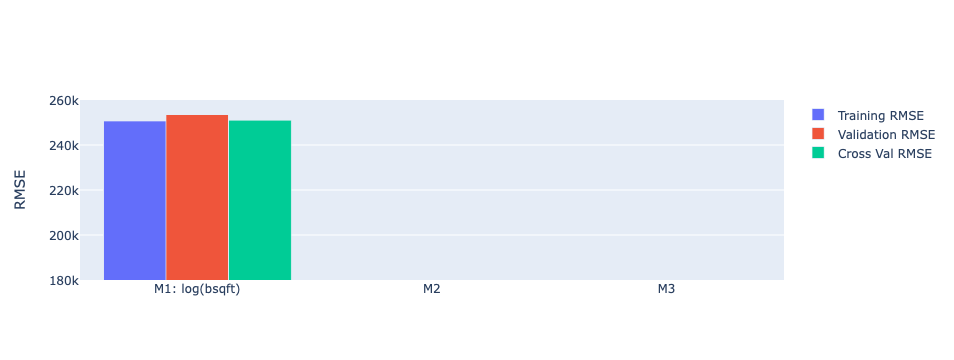

In [126]:
# Just run this cell.  It creates a visualization of the RMSE for Model 1

import plotly.graph_objects as go

fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig

Notice that our cross-validation RMSE is pretty high given that it's in the units of dollars and measures our error when predicting sale prices of a house.  We will want to improve this model!

<br>

--- 

## Visualizing Residual Plots

Another way of understanding a model's performance (and appropriateness) is through a plot of the residuals versus the observations.  We will use the validation data to create these plots.

In the cells below, use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot
2 side-by-side residual plots:

 - The first plot should be of the residuals from predicting `Log Sale Price` using the model versus  the **predicted** `Log Sale Price` for the **validation data**. 
 - The second plot should be the residuals from predicting `Log Sale Price` using the model versus the **actual** `Log Sale Price` for the **validation data**. 

We will keep the residuals in terms of units of log to make it easier to spot trends.

With such a large dataset, it is difficult to avoid overplotting entirely. We set the dot size and opacity in the scatter plot to reduce the impact of overplotting as much as possible.

## QUESTION 4f:  Complete the code below to plot the residual plots

Text(0.5, 1.0, 'Model 1 Val Data: Residuals vs. Log(Sale Price)')

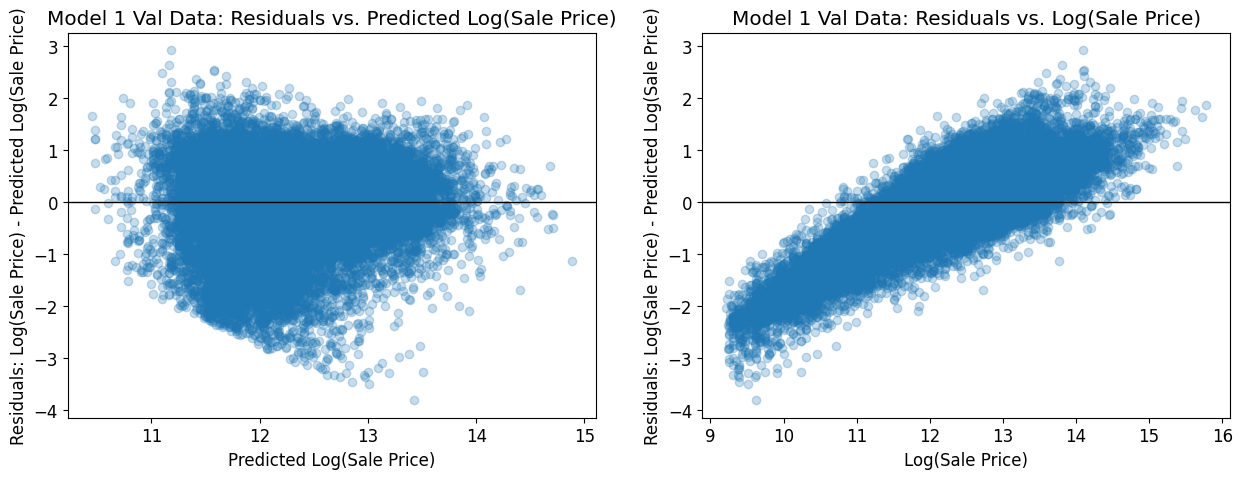

In [127]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

residuals = y_valid_m1 - y_predict_valid_m1

x_plt1 = y_predict_valid_m1
y_plt1 = residuals

x_plt2 = y_valid_m1
y_plt2 = residuals



ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 1 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 1 Val Data: Residuals vs. Log(Sale Price)")

In [128]:
grader.check("q4f")

q4f results: All test cases passed!

**NOTE** Notice in the first plot it appears that the lower part of the plot is cutoff along an angled line - this is due to us filtering the data by only considering "Pure Market Filter" = 1, it is not a "pattern" in the residuals that we should try to address.

<br>


--- 

### Question 4g

Based on the structure you see in your residual plots, does this model seem like it will correspond to _regressive_, _fair_, or _progressive_ taxation?

Assign the string "regressive", "fair" or "progressive" to `q4g` in the cell below accordingly.

**Hidden test in Gradescope**:  Since this is a question with only 3 possible answers, the in-notebook test will only check if you have the correct format for your answer, it won't check if your actual answer is correct. 

In [129]:
q4g = "progressive"

In [130]:
grader.check("q4g")

q4g results: All test cases passed!

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Question 5:  Adding a New Feature


While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement to be made -- one reason is we have been only utilizing 1 feature (out of a total of 60+) so far! 

### Choosing Candidate Predictors to Add to Model



To see if additional variables might be helpful, we can plot the residuals from the fitted model against a variable that is not in the model. If we see patterns, that indicates we might want to include this additional feature or a transformation of it. 

In Project Part 1, you conducted feature transformation to create several other features related to the Sale Price including `Bedrooms` and `Roof Material`.
Let's examine plots of the residuals from Model 1 vs each of these features.

We have automatically imported staff implementations of the functions you wrote in Project 1 (these are stored in `feature_func.py`).  You are welcome to copy over your own implementations from Project 1 if you'd prefer. 

These functions are:

 - `add_total_bedrooms`, 
 - `find_expensive_neighborhoods`, 
 - `add_in_expensive_neighborhood`,
 - `ohe_roof_material`,
 -  `remove_outliers`,  


In [131]:
# Just run this cell - it creates the columns of the 2 additional features 
# we're interested in considering to add to the model 
# and appends the residual data from Model 1, so we can easily visualize

from feature_func import *


def process_data_candidates(df):
    
    data = df.copy()
    
    data["Log Sale Price"] = np.log(data["Sale Price"])
    
    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    
    
    # Create Bedrooms
    data = add_total_bedrooms(data)
     
   
    # Update Roof Material feature with names
    data = substitute_roof_material(data)

    
    # Select columns for comparing residuals
    data = data[['Log Building Square Feet',  'Roof Material', 'Bedrooms', 'Log Sale Price']]

    return data


#Since our residuals are using the validation data, we will just examine these new features on the validation dataset
    
valid_comp = process_data_candidates(val)
    
valid_comp = valid_comp.assign(M1residuals_log=y_valid_m1 - y_predict_valid_m1)


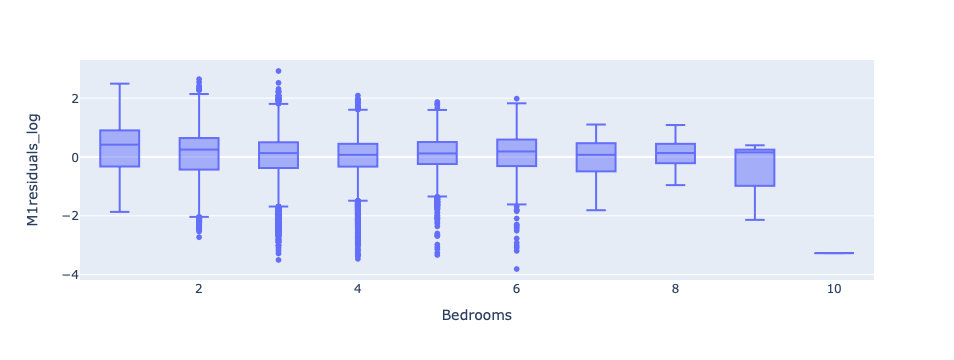

In [132]:
# Run this cell to compare residuals with Bedrooms

import plotly.express as px

px.box(valid_comp, x='Bedrooms', y='M1residuals_log')


Notice, with the exception of the outlier (the properties with 10 bedrooms), the medians of each boxplot align pretty close to 0 on the y-axis (meaning there is no major trend in prediction errors by Number of Bedrooms).

This means we do NOT expect adding the features Bedrooms will help improve our original model. 

What about Roof Material?


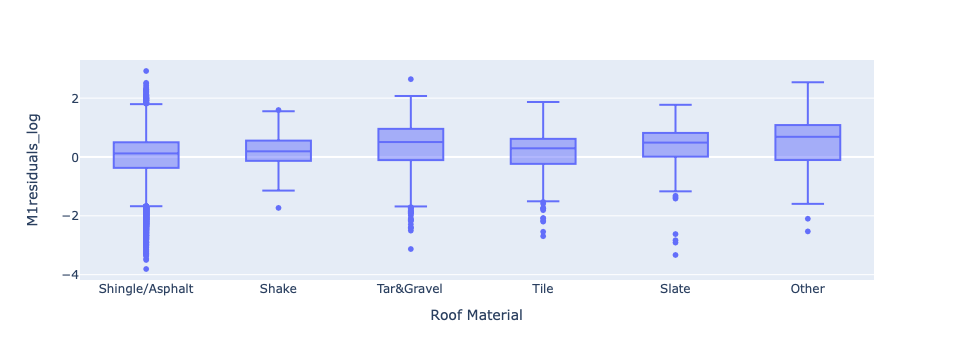

In [133]:
# Run this cell to compare residuals vs Roof Material

px.box(valid_comp, x='Roof Material', y='M1residuals_log')

The plot above shows us that the distribution of errors appears to change slightly based on Roof Material. Ideally, the median of each  box plot lines up with 0 on the y-axis (meaning there was no difference in prediction by Roof Material type). Instead, we see some variation from 0 for all except Shingle/Asphalt.   These patterns suggest that we may want to try including Roof Material in the model.


## Question 5a:  Model 2

Let's add `Roof Material` as a predictor in our model.  We will transform the column to be in terms of the Room Material names (like you did in Project Part 1, instead of the number codes).   In other words, let's consider a model of the form:

Model 2: 
$$\text{Log Sale Price} =  \theta_1(\text{Log Building Square Feet})  +\theta_2 (\text{Shingle/Asphalt}) $$

$$+ \theta_3 (\text{Tar\&Gravel}) + \theta_4  (\text{Tile})+ \theta_5 (\text{Shake})+  \theta_6(\text{Other})+\theta_7(\text{Slate})$$




**Note:** This will require one-hot-encoding Roof Material.  Notice since we're one-hot-encoding we don't need to include an extra intercept term in the model. 

In the cells below fill in the code to create a function `process_data_m2` to apply feature transformations to the features we'll use in Model 2

#### Modeling Step 1:  Process the Data


In [134]:
# Modeling Step 1:  Process the Data

# Hint: You can either use your implementation of the 
# One Hot Encoding Function from Project Part 1, or use the staff's implementation 
# imported from the feature_func.py file:

from feature_func import *
from sklearn.preprocessing import OneHotEncoder

# Optional:  Define any helper functions you need for one-hot encoding above this line


def process_data_m2(df):
    """ 
    Takes in a DataFrame of cleaned data and performs feature engineering to use for Model 2.
    Includes creating a Log Sale Price column, a Log Building Square Feet column, 
    and one-hot encoding Roof Material. Drops the original 'Roof Material' column 
    after encoding it.

    Outputs a DataFrame with only the features and response/output used in Model 2.
    """
    data = df.copy()
    
    # Create Log Sale Price column
    data['Log Sale Price'] = np.log(data['Sale Price'])
    
    # Create Log Building Square Feet column
    data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
    
    # One-hot encode Roof Material
    data = ohe_roof_material(data)
    
    # Drop the original Roof Material column
    data = data.drop(columns=['Roof Material'])
    
    # Keep only necessary columns for the model
    features = ['Log Building Square Feet'] + [col for col in data.columns if col.startswith('Roof Material_')]
    target = 'Log Sale Price'
    data = data[features + [target]]
    
    return data


# Assume tr and val are predefined training and validation datasets
processed_train_m2 = process_data_m2(tr)
processed_val_m2 = process_data_m2(val)

# Create X (features) and y (target) for train and validation datasets
X_train_m2 = processed_train_m2.drop(columns=['Log Sale Price'])
y_train_m2 = processed_train_m2['Log Sale Price']

X_valid_m2 = processed_val_m2.drop(columns=['Log Sale Price'])
y_valid_m2 = processed_val_m2['Log Sale Price']

# Display the results
display(X_train_m2.head())
display(y_train_m2.head())
display(X_valid_m2.head())
display(y_valid_m2.head())

Log Building Square Feet  Roof Material_1.0  Roof Material_2.0  \
21302                   6.871091                1.0                0.0   
19451                   7.576610                1.0                0.0   
32018                   6.891626                1.0                0.0   
144262                  7.186901                1.0                0.0   
197227                  7.576610                1.0                0.0   

        Roof Material_3.0  Roof Material_4.0  Roof Material_5.0  \
21302                 0.0                0.0                0.0   
19451                 0.0                0.0                0.0   
32018                 0.0                0.0                0.0   
144262                0.0                0.0                0.0   
197227                0.0                0.0                0.0   

        Roof Material_6.0  
21302                 0.0  
19451                 0.0  
32018                 0.0  
144262                0.0  
197227                0.0

21302     11.738466
19451     12.100712
32018     12.577291
144262    12.502467
197227    12.449019
Name: Log Sale Price, dtype: float64

Log Building Square Feet  Roof Material_1.0  Roof Material_2.0  \
17112                   7.487174                1.0                0.0   
189337                  7.688913                1.0                0.0   
141725                  6.985642                1.0                0.0   
9776                    6.846943                1.0                0.0   
81676                   7.096721                1.0                0.0   

        Roof Material_3.0  Roof Material_4.0  Roof Material_5.0  \
17112                 0.0                0.0                0.0   
189337                0.0                0.0                0.0   
141725                0.0                0.0                0.0   
9776                  0.0                0.0                0.0   
81676                 0.0                0.0                0.0   

        Roof Material_6.0  
17112                 0.0  
189337                0.0  
141725                0.0  
9776                  0.0  
81676                 0.0

17112     12.100707
189337    12.460715
141725    12.165251
9776      11.982929
81676     11.719940
Name: Log Sale Price, dtype: float64

In [135]:
grader.check("q5ai")

q5ai results: All test cases passed!

#### Modeling STEP 2:  Create a Multiple Linear Regression Model

In [136]:
# Modeling STEP 2:  Create and Fit a Multiple Linear Regression Model
linear_model_m2 = lm.LinearRegression()
linear_model_m2.fit(X_train_m2, y_train_m2)

# your code above this line to create and fit regression model for Model 2

y_predict_train_m2 = linear_model_m2.predict(X_train_m2)
y_predict_valid_m2 = linear_model_m2.predict(X_valid_m2)

In [137]:
grader.check("q5aii")

q5aii results: All test cases passed!

#### MODELING STEP 3:  Evaluate the RMSE for your model

In [138]:
# MODELING STEP 3:  Evaluate the RMSE for your model


# Training and test errors for the model (in its original values of dollars, not log)

# training_error_log[1] = rmse(y_predict_train_m2, y_train_m2)
# validation_error_log[1] = rmse(y_predict_valid_m2, y_valid_m2)

# Calculate RMSE for training and validation

training_error[1] = rmse(np.exp(y_predict_train_m2), np.exp(y_train_m2))
validation_error[1] = rmse(np.exp(y_predict_valid_m2), np.exp(y_valid_m2))


print("2nd Model \nTraining RMSE: $ {}\nValidation RMSE: $ {}\n".format(training_error[1], validation_error[1]))


2nd Model 
Training RMSE: $ 242876.62843606115
Validation RMSE: $ 245529.28812096393



In [139]:
grader.check("q5aiii")

q5aiii results: All test cases passed!

#### MODELING STEP 4:  Conduct 5-fold cross validation for model and output CV RMSE

In [140]:
# MODELING STEP 4:  Conduct 5-fold cross validation for model and output CV RMSE

# Create a new model to use for cross validation of m2 
linear_model_m2_cv = lm.LinearRegression()


# Process the entire cleaned training_val dataset using the m2 pipeline
processed_full_m2 = process_data_m2(tr_val_clean)

# Split the processed_full_m2 Dataset into X and Y to use in models.
X_full_m2 = processed_full_m2.drop(columns="Log Sale Price")
y_full_m2 = processed_full_m2["Log Sale Price"]


# Run cross_validate_rmse function:
cv_error_m2  = cross_validate_rmse(linear_model_m2_cv, X_full_m2, y_full_m2)

# Save the cross validation error for model 1 in our list to compare different models:

cv_error[1] = cv_error_m2

print("2nd Model Cross Validation RMSE: {}".format(cv_error[1]))







2nd Model Cross Validation RMSE: 243152.29260846158


In [141]:
grader.check("q5aiv")

q5aiv results: All test cases passed!

#### MODELING STEP 5:  Just run this cell to Plot bar graph comparing RMSEs of Model 2 and Model 1 and side-by-side residuals


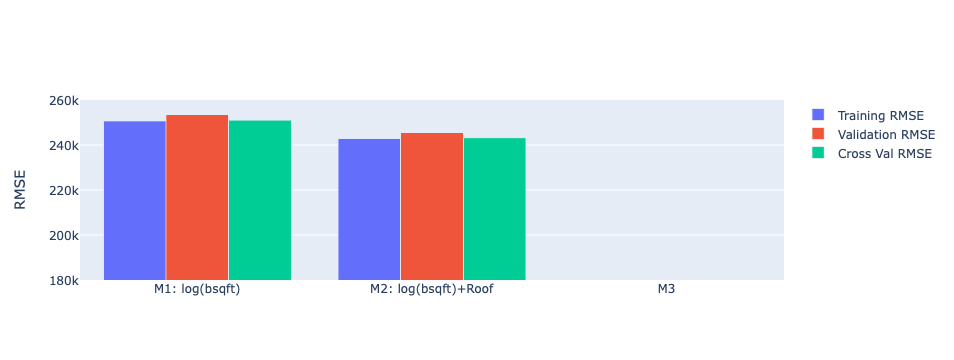

In [142]:
# MODELING STEP 5:  Just run this cell to Plot bar graph comparing RMSEs of Model 2 and Model 1 and side-by-side residuals

model_names[1] = "M2: log(bsqft)+Roof"

fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig


Text(0.5, 1.0, 'Model 2 Val Data: Residuals vs. Log(Sale Price)')

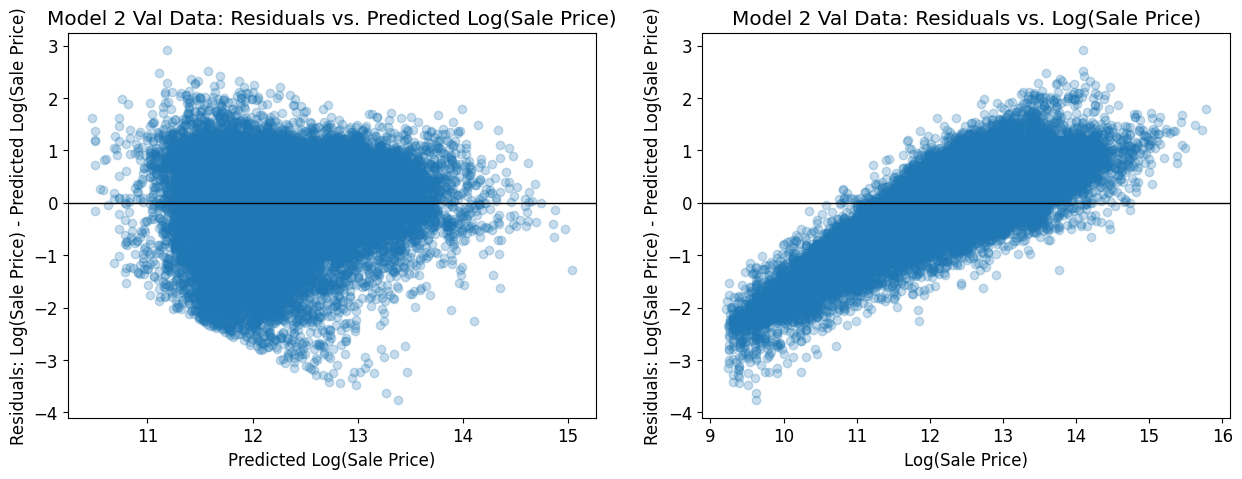

In [143]:
# MODELING STEP 5 cont'd:  Plot 2 side-by-side residual plots (similar to Question 3, for validation data)

fig, ax = plt.subplots(1,2, figsize=(15, 5))

residuals = y_valid_m2 - y_predict_valid_m2

x_plt1 = y_predict_valid_m2
y_plt1 = residuals

x_plt2 = y_valid_m2
y_plt2 = residuals


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 2 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 2 Val Data: Residuals vs. Log(Sale Price)")


In [144]:
grader.check("q5av")

q5av results: All test cases passed!

### Question 5b


We only see a slight decrease in the RMSE with this 2nd model, and our residuals look nearly the same as Model 1, even though the boxplots of Roof Material vs the residuals of Model 1 had indicated it might be a useful feature to add to the model.  

What went wrong?
  
Although there was variation in the boxplots we didn't check the number of data points actually in each different Roof Material Category, which will affect how useful the feature will be in reducing the RMSE.  

To see this, group the `valid_comp` data by Roof Material Type and calculate the proportion of data in each category.  

Set the variable `val_data_prop_roof_type` equal to a `series` with indices given by Roof Material Name and values that are the proportion of validation data of that roof type.

(for example `val_data_prop_roof_type["Shingle/Asphalt"]` should return a float that is the proportion of data points with that type of roof)

In [145]:
val_data_prop_roof_type = valid_comp.groupby("Roof Material").size() / len(valid_comp)

val_data_prop_roof_type

Roof Material
Other              0.005497
Shake              0.008783
Shingle/Asphalt    0.952293
Slate              0.003794
Tar&Gravel         0.022793
Tile               0.006841
dtype: float64

In [146]:
grader.check("q5b")

q5b results: All test cases passed!


<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 6:  Improving the Model



<!-- BEGIN QUESTION -->

### Question 6a:  Choose an additional feature

It's your turn to choose another feature to add to the model.  Choose one new **quantitative** (not qualitative) feature and create Model 3 incorporating this feature (along with the features we've already chosen in Model 2).    Try to choose a feature that will have a large impact on reducing the RMSE and/or will improve your residual plots.  This can be a raw feature available in the dataset, or a transformation of one of the features in the dataset, or a new feature that you create from the dataset (see Project 1 for ideas).    

Note:  There is not one single right answer as to which feature to add, however **to receive credit on this question you should make sure the feature decreases the Cross Validation RMSE compared to Model 2 (i.e. we want to improve the model, not make it worse!)** 


In the cell below, explain what additional feature you have chosen and why.  Justify your reasoning.  There are optional code cells provided below for you to use when exploring the dataset to determine which feature to add. 

This problem will be graded based on your reasoning and explanation of the feature you choose, and then on your implementation of incorporating the feature.   

**NOTE** Please don't add additional coding cells below or the Autograder will have issues.  You do not need to use all the coding cells provided.   

### Question 6a Answer Cell:   
In this cell, explain what feature you chose to add and why. Then give the equation for your new model (use the LaTeX from Model 2 from above and then add an additional term).   


$$\text{Log Sale Price} =  \theta_1(\text{Log Building Square Feet})  +\theta_2 (\text{Shingle/Asphalt}) $$

$$+ \theta_3 (\text{Tar\&Gravel}) + \theta_4  (\text{Tile})+ \theta_5 (\text{Shake})+  \theta_6(\text{Other})+\theta_7(\text{Slate}) +\theta_8(\text{Estimate (Building)})$$

I was originally going to incorporate the Age Decade column as the age of the house usually plays a decent role in determining the property's overall value. Depending on the property, age could either increase of decrease a property's value due to depreciation or vintage styling choices. Similarly, older houses have more wear and tear which may also decrease its overall value, so it seemed like a good choice to help improve the model. However, once I got to calculating the RMSE, the value was higher than before, so I chose the next qualitative column I saw: Neighborhood Code. However, that also was not optimal in improving my RMSE value, which led me to use Building (Estimate). Building (Estimate) seems to be the estimated sale price for the property, so it sounds like it would also be a good feature to add to the model since we're dealing with sale prices.

In [147]:
tr_val_data["Age Decade"].unique()

# Show work in this cell exploring data to determine which feature to add

array([13.2,  9.6, 11.2,  6.3,  5.8, 10.9,  1.7, 10. ,  4.8,  7.4,  3.4,
        1.3, 12.2,  1.6,  5.9,  9.4,  8.7,  4.1,  6.5,  6.9,  0.1,  6.4,
        9.5,  2.7,  9.2,  6.2,  7.3,  6.7, 10.7,  9.3,  5.4,  3.3,  4. ,
        0.7,  9.1,  4.2,  1. ,  3.8,  2.8,  2.5, 10.2,  4.9,  5.7,  6.1,
        3. ,  3.9,  6.6, 10.1,  7.1,  4.7,  0.9,  5.1,  6. ,  8.8, 10.5,
        7.5,  8.9,  7.7,  4.4,  4.6, 11.5,  9. ,  6.8, 11.7,  4.3, 10.6,
        5.5, 11. ,  8.5,  3.7,  7.6, 13.4,  8. , 12.9,  4.5,  5. ,  1.9,
        8.4,  5.3,  3.5,  0.8,  0.4, 12.3, 14. ,  5.6,  7.8,  3.6, 12.1,
       11.8,  8.6,  3.1, 12.7, 12.8,  1.5,  2.9,  5.2,  1.8,  8.3,  8.2,
       10.4,  9.8,  9.7, 11.4, 11.3,  9.9,  2.4,  7. , 12. , 11.6, 11.1,
       12.5,  3.2, 12.4, 13.6,  7.2,  2.1, 10.3,  2.2,  2. , 10.8, 13.3,
        0.6, 15. , 13. ,  0.5,  1.2,  7.9, 13.7,  1.4,  2.6, 14.3,  1.1,
       11.9,  8.1, 12.6, 14.7, 14.4, 15.1, 13.5,  2.3, 14.2, 13.1, 13.9,
       13.8, 15.5, 14.8, 14.1, 14.5, 15.9,  0.3, 17

count    204792.000000
mean          6.598121
std           2.900149
min           0.100000
25%           5.100000
50%           6.200000
75%           8.900000
max          17.200000
Name: Age Decade, dtype: float64

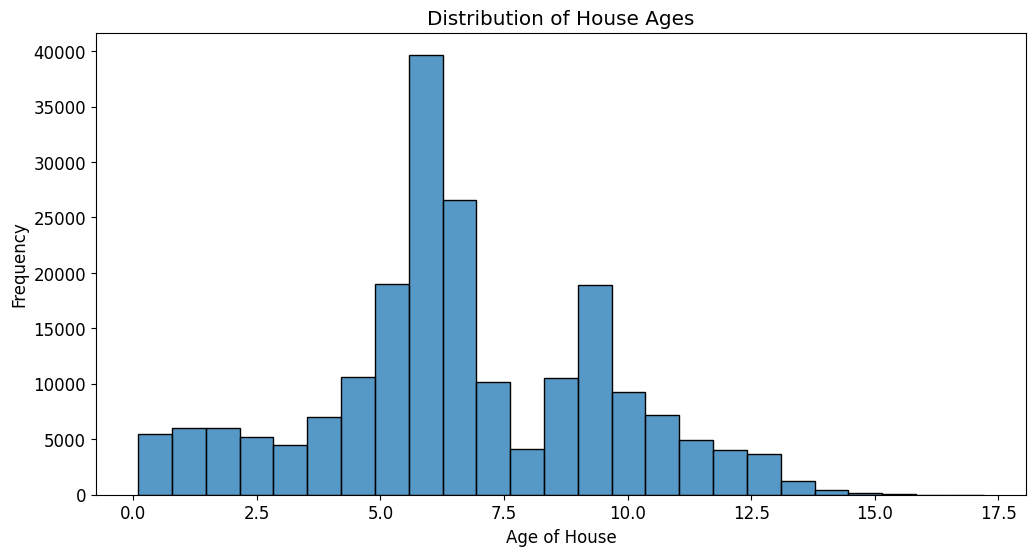

In [148]:
display(tr_val_data['Age Decade'].describe())
plt.figure(figsize=(12, 6))
sns.histplot(tr_val_data['Age Decade'], bins = 25)
plt.title("Distribution of House Ages")
plt.xlabel("Age of House")
plt.ylabel("Frequency")
plt.show()

# Optional code cell for additional work exploring data/ explaining which feature you chose.

In [149]:
tr_val_data['Neighborhood Code'].unique()

# Optional code cell for additional work exploring data/ explaining which feature you chose.

array([ 50, 120, 210, 220, 380, 181,  52,  70,  33,  20,  21,  30, 100,
        40,  61,  24, 282,  11, 112, 130, 240,  60,  10,  41,  92, 330,
        31,  32,  93,  51, 520,  84,  85,  88, 180, 110, 194, 160,  71,
       171,  22, 141, 113,  80,  13, 440, 212, 200,  45, 250, 190, 274,
       150,  35, 422, 162, 142, 260,  81, 314,  82,  42, 361, 430,  74,
       410, 103, 420, 321, 102,  12,  23, 132, 122, 101, 350, 151, 223,
       115,  90, 323,  91,  63, 270, 281,  15, 280, 560,  14, 170, 211,
       111, 191, 271,  55, 251, 104, 221, 241,  53, 371,  72, 461,  75,
       342, 345, 175, 320,  43,  62, 423, 140, 230, 362,  94,  34, 193,
       310, 121,  54, 390,  46, 344, 114,  19,  44,  65, 431, 166, 131,
        47, 312, 275, 161,  39, 257,  83, 255, 183, 192,  73,  36, 222,
       316,  96, 164, 315, 580,  64, 300,  26, 224,  87, 226, 400, 152,
        56,  25, 293, 402, 182, 174, 340, 201, 133, 116, 185,  27, 600,
       432, 165,  48,  37,  67, 360, 262, 232, 134,  99, 117, 22

In [150]:
tr_val_data['Estimate (Building)'].unique()

# Optional code cell for additional work exploring data/ explaining which feature you chose.

array([139500, 177500,  63470, ..., 635930, 537990, 637720])

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b:  Create Model 3

In the cells below fill in the code to create and analyze Model 3 (follow the Modeling steps outlined above).

PLEASE DO NOT ADD ANY ADDITIONAL CELLS IN THIS PROBLEM OR IT MIGHT MAKE THE AUTOGRADER FAIL

In [151]:
# Modeling Step 1:  Process the Data

# Hint: You can either use your implementation of the One Hot Encoding Function 
#from Project Part 1, or use the staff's implementation

from feature_func import *

...
# Optional:  Define any helper functions you need for one-hot encoding above this line


def process_data_m3(df):
    
    data = df.copy()
    
    data = data[data["Pure Market Filter"]==1]

    # Create Log Sale Price column
    data["Log Sale Price"] = np.log(data["Sale Price"])

    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])

    # Create Log Estimate (Building) column
    data["Log Estimate (Building)"] = np.log(data["Estimate (Building)"] + 1)

    # Change Roof Material to names
    data = substitute_roof_material(data)

    # one-hot encode the roof material
    data = ohe_roof_material(data)

    # select only relevant columns
    relevant_columns = ['Log Estimate (Building)', 'Log Building Square Feet', 'Log Sale Price'] + [col for col in data.columns if "Roof Material_" in col]
    data = data[relevant_columns]


    
    return data

    

# Process the data for Model 3 (using the same tr and val datatsets we created in Question 3) 
processed_train_m3 = process_data_m3(tr) 

processed_val_m3 = process_data_m3(val) 

# Create X (Dataframe) and y (series) to use to train the model
X_train_m3 = processed_train_m3.drop(columns = ['Log Sale Price'])
y_train_m3 = processed_train_m3['Log Sale Price']

X_valid_m3 = processed_val_m3.drop(columns = ['Log Sale Price'])
y_valid_m3 = processed_val_m3['Log Sale Price']


# Take a look at the result
display(X_train_m3.head())
display(y_train_m3.head())

display(X_valid_m3.head())
display(y_valid_m3.head())


Log Estimate (Building)  Log Building Square Feet  \
21302                 11.248061                  6.871091   
19451                 11.510031                  7.576610   
32018                 12.096431                  6.891626   
144262                12.042265                  7.186901   
197227                12.612640                  7.576610   

        Roof Material_Other  Roof Material_Shake  \
21302                   0.0                  0.0   
19451                   0.0                  0.0   
32018                   0.0                  0.0   
144262                  0.0                  0.0   
197227                  0.0                  0.0   

        Roof Material_Shingle/Asphalt  Roof Material_Slate  \
21302                             1.0                  0.0   
19451                             1.0                  0.0   
32018                             1.0                  0.0   
144262                            1.0                  0.0   
197227                            1.0                  0.0   

        Roof Material_Tar&Gravel  Roof Material_Tile  
21302                        0.0                 0.0  
19451                        0.0                 0.0  
32018                        0.0                 0.0  
144262                       0.0                 0.0  
197227                       0.0                 0.0

21302     11.738466
19451     12.100712
32018     12.577291
144262    12.502467
197227    12.449019
Name: Log Sale Price, dtype: float64

Log Estimate (Building)  Log Building Square Feet  \
17112                 11.882217                  7.487174   
189337                12.110118                  7.688913   
141725                11.760418                  6.985642   
9776                  11.569599                  6.846943   
81676                 11.272776                  7.096721   

        Roof Material_Other  Roof Material_Shake  \
17112                   0.0                  0.0   
189337                  0.0                  0.0   
141725                  0.0                  0.0   
9776                    0.0                  0.0   
81676                   0.0                  0.0   

        Roof Material_Shingle/Asphalt  Roof Material_Slate  \
17112                             1.0                  0.0   
189337                            1.0                  0.0   
141725                            1.0                  0.0   
9776                              1.0                  0.0   
81676                             1.0                  0.0   

        Roof Material_Tar&Gravel  Roof Material_Tile  
17112                        0.0                 0.0  
189337                       0.0                 0.0  
141725                       0.0                 0.0  
9776                         0.0                 0.0  
81676                        0.0                 0.0

17112     12.100707
189337    12.460715
141725    12.165251
9776      11.982929
81676     11.719940
Name: Log Sale Price, dtype: float64

In [152]:
# Modeling STEP 2:  Create and Fit a Multiple Linear Regression Model


linear_model_m3 = lm.LinearRegression(fit_intercept=False)

linear_model_m3.fit(X_train_m3, y_train_m3)

# your code above this line to create and fit regression model for Model 3

y_predict_train_m3 = linear_model_m3.predict(X_train_m3)

y_predict_valid_m3 = linear_model_m3.predict(X_valid_m3)




In [153]:
# MODELING STEP 3:  Evaluate the RMSE for your model


# Training and validation errors for the model (in units dollars, not log(dollars))

training_error[2] = rmse(y_predict_train_m3, y_train_m3)
validation_error[2] = rmse(y_predict_valid_m3, y_valid_m3)

training_error[2] = rmse(np.exp(y_predict_train_m3), np.exp(y_train_m3))
validation_error[2] = rmse(np.exp(y_predict_valid_m3), np.exp(y_valid_m3))

(print("3rd Model \nTraining RMSE: $ {}\nValidation RMSE: {}\n"
       .format(training_error[2], validation_error[2]))
)


3rd Model 
Training RMSE: $ 232349.50469106025
Validation RMSE: 234597.11998179482



In [154]:

# MODELING STEP 4:  Conduct 5-fold cross validation for model and output RMSE

linear_model_m3_cv = lm.LinearRegression(fit_intercept=False)


# Process the entire cleaned training_val dataset using the m3 pipeline
processed_full_m3 = process_data_m3(tr_val_data)

# Split the processed_full_m3 Dataset into X and y to use in models.
X_full_m3 = processed_full_m3.drop(columns="Log Sale Price")
y_full_m3 = processed_full_m3["Log Sale Price"]


# Run cross_validate_rmse function:
cv_error_m3  = cross_validate_rmse(linear_model_m3_cv, X_full_m3, y_full_m3)

# Save the cross validation error for model 3 in our list to compare different models:

cv_error[2] = cv_error_m3

print("3rd Model Cross Validation RMSE: {}".format(cv_error[2]))




3rd Model Cross Validation RMSE: 232477.29879016159


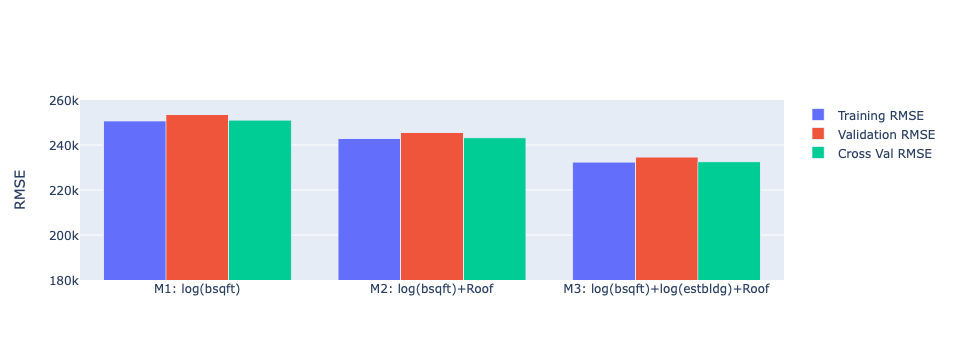

In [155]:
# MODELING STEP 5:  Add a name for your 3rd model describing the features 
#and run this cell to Plot bar graph all 3 models

model_names[2] = "M3: log(bsqft)+log(estbldg)+Roof"


fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig


Text(0.5, 1.0, 'Model 3 Val Data: Residuals vs. Log(Sale Price)')

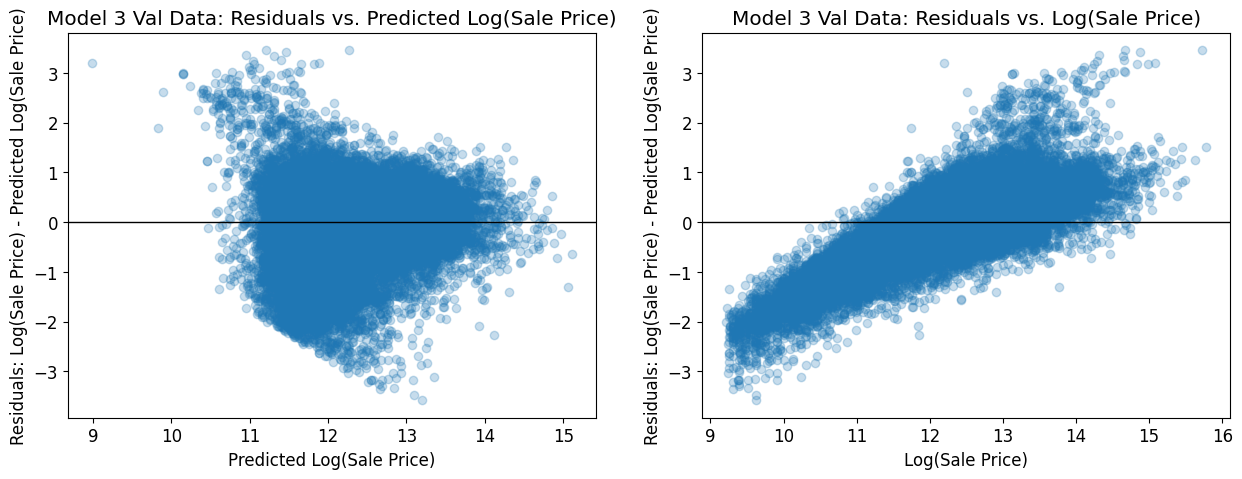

In [156]:
# MODELING STEP 5 cont'd:  Plot 2 side-by-side residual plots 
#(similar to Question 3, for validation data)

fig, ax = plt.subplots(1,2, figsize=(15, 5))

residuals = y_valid_m3 - y_predict_valid_m3

x_plt1 = y_predict_valid_m3
y_plt1 = residuals

x_plt2 = y_valid_m3
y_plt2 = residuals


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 3 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 3 Val Data: Residuals vs. Log(Sale Price)")


In [157]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

 - 6ci).  Comment on your RMSE and residual plots from Model 3 compared to the first 2 models.  

 - 6cii).  Are the residuals of your model still showing a trend that overestimates lower priced houses and underestimates higher priced houses?   If so, how could you try to address this in the next round of modeling?

 - 6ciii).  If you had more time to improve your model, what would your next steps be?


6ci). The RMSE and residual plots from Model 3 seem to be better than the first two models. Since the distribution is more evenly distributed around 0, we can tell that the estimation of houses is more accurate to their actual values.

6cii). There is still a slight trend which we can try and accomodate for by adding more features in future models. For instance, we could try and incorporate other features that may be closely correlated with the sale price so as to avoid the over and underestimation.

6ciii). If I had more time to improve my model, I would go back and try to incorporate age as I feel that would be a good factor. I was originally going to incorporate that, but messed up somewhere so with more time, I would try and debug it to see if it would work.

<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

## Question 7: Evaluating the Model in Context

<br>

<!-- BEGIN QUESTION -->

---
## Question 7a

When evaluating your model, we used RMSE. In the context of estimating the value of houses, what does the residual mean for an individual homeowner? How does it affect them in terms of property taxes? Discuss the cases where residual is positive and negative separately.

When the residual is positive, the model underestimates the house's value. This might mean lower property taxes for the homeowner, but they might not realize how much their house is really worth if they sell. When it's negative, the model overestimates the house's value, which could lead to higher property taxes. This is especially unfair for people with lower-cost homes since they may end up paying more than they should. Overall, when the model is wrong, it can either save homeowners money or cost them, depending on whether the predicted price is too low or too high.

<!-- END QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. Fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).

<!-- BEGIN QUESTION -->

<br>

---

## Question 7b

Reflecting back on your exploration in Questions 5 and 6a, in your own words, what makes a model's predictions of property values for tax assessment purposes "fair"? 

This question is open-ended and part of your answer may depend upon your specific model; we are looking for thoughtfulness and engagement with the material, not correctness. 

**Hint:** Some guiding questions to reflect on as you answer the question above: What is the relationship between RMSE, accuracy, and fairness as you have defined it? Is a model with a low RMSE necessarily accurate? Is a model with a low RMSE necessarily "fair"? Is there any difference between your answers to the previous two questions? And if so, why?

A fair model should avoid large errors and shouldn't be influenced by homeowners' socio-economic status or legal biases. It's important that the residual plot is evenly and tightly distributed around 0, since unfair taxes can create serious financial troubles for many people.

<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

## Extra Credit:  How Low Can You Go?   Create Your Own Model and Check RMSE on the Test Data

<br>

---



For **extra credit**, you can create your own model to try to improve the RMSE and residual plots even further. 

The tables below provide scoring guidelines for the extra credit opportunity in this problem. 
If your RMSE lies in a particular range, you will receive the number of points associated with that range.



### Extra Credit Grading Scheme

**Important**: To avoid memory issues we will only be using simple cross validation, not 5-fold cross validation in this extra credit part.  While your Validation RMSE can be checked at any time in this notebook, your Test RMSE can only be checked once by submitting your model’s predictions to Gradescope. The thresholds are as follows:

Extra Credit Points | +10 | +8 | +6  | +4 | + 2
--- | --- | --- | --- | --- | ---
Validation RMSE | Less than 200k | [200k, 210k) | [210k, 220k) | [220k, 230k)  | [230k, 235k)

Extra Credit Points | +10 | +8 | +6  | +4 | + 2
--- | --- | --- | --- | --- | ---
Test RMSE | Less than 200k | [200k, 210k) | [210k, 220k) | [220k, 230k)| [230k, 235k)

<br><br>

To receive these points, you need to show your work in the cells below AND complete the EXPLANATION STEP at the end (explaining what you did to create your model).  

You ALSO MUST UPLOAD your test prediction .csv to the **"Project 2 Extra Credit Test Predictions"** assignment in Gradescope to receive extra credit for your test predictions.

---

## Some notes before you start

- **If you are running into memory issues, restart the kernel and only run the cells you need to.**   If needed you can use the commented cell below (question cell) that contains most to all of the imports necessary to successfully complete this portion of the project, so it can be completed independently code-wise from the remainder of the project, and you do not need to rerun the cell at the top of this notebook. The autograder will have more than 4GB of memory, so you will not lose credit as long as your solution to this question is within the total memory (4GB) limits of DataHub. By default, we reset the memory and clear all variables using `%reset -f`. If you want to delete specific variables, you may also use `del` in place of `%reset -f%`. For example, the following code will free up memory from data used for older models: `del tr_val_data, test_data, tr, val, X_train_m1, X_valid_m1, X_train_m2, X_valid_m1`. Our staff solution can be run independently from all other questions, so we encourage you to do the same to make debugging easier.
- Tip: Feel free to try using [regularization](https://learningds.org/ch/16/ms_regularization.html) for model selection. 
- To avoid memory issues, you do not need to include cross validation for this step.  Your score will be based on the Validation Data set RMSE and the Test dataset RMSE.
- **Note: If you need the data again after deleting the variables or resetting, you must reload them again.**
- You will be predicting `Log Sale Price` on the data stored in `cook_county_contest_test.csv`. We will delog/exponentiate your prediction on Gradescope to compute RMSE and use this to score your model. Before submitting to Gradescope, make sure that your predicted values can all be delogged (i.e., if one of your `Log Sale Price` predictions is 60, it is too large; $e^{60}$ is too big!)
- You MUST remove any additional new cells you add before submitting to Gradescope to avoid any autograder errors. 


**PLEASE READ THE ABOVE MESSAGE CAREFULLY!**

**Hints:** 
- Some features may have missing values in the test set but not in the training set (especially if you're one-hot-encoding). Make sure `process_data_ec` handles missing values appropriately for each feature!



In [169]:
tr_val_data["Neighborhood Code"].unique()

# Optional code cell for additional work exploring data/ explaining which feature you chose.
# You can add additional code cells directly below this if needed.

array([ 50, 120, 210, 220, 380, 181,  52,  70,  33,  20,  21,  30, 100,
        40,  61,  24, 282,  11, 112, 130, 240,  60,  10,  41,  92, 330,
        31,  32,  93,  51, 520,  84,  85,  88, 180, 110, 194, 160,  71,
       171,  22, 141, 113,  80,  13, 440, 212, 200,  45, 250, 190, 274,
       150,  35, 422, 162, 142, 260,  81, 314,  82,  42, 361, 430,  74,
       410, 103, 420, 321, 102,  12,  23, 132, 122, 101, 350, 151, 223,
       115,  90, 323,  91,  63, 270, 281,  15, 280, 560,  14, 170, 211,
       111, 191, 271,  55, 251, 104, 221, 241,  53, 371,  72, 461,  75,
       342, 345, 175, 320,  43,  62, 423, 140, 230, 362,  94,  34, 193,
       310, 121,  54, 390,  46, 344, 114,  19,  44,  65, 431, 166, 131,
        47, 312, 275, 161,  39, 257,  83, 255, 183, 192,  73,  36, 222,
       316,  96, 164, 315, 580,  64, 300,  26, 224,  87, 226, 400, 152,
        56,  25, 293, 402, 182, 174, 340, 201, 133, 116, 185,  27, 600,
       432, 165,  48,  37,  67, 360, 262, 232, 134,  99, 117, 22

In [170]:
tr_val_data["Town Code"].unique()
# Optional code cell for additional work exploring data/ explaining which feature you chose.

array([76, 71, 70, 17, 32, 72, 37, 25, 29, 31, 38, 35, 18, 22, 28, 34, 36,
       23, 24, 19, 16, 73, 20, 21, 39, 12, 13, 77, 27, 74, 11, 10, 33, 15,
       75, 30, 26, 14])

In [171]:
#Optional cell to try if you're having memory issues (i.e. if kernel keeps dying)
tr_val_data["Property Class"].unique()

# If you're having memory issues, uncomment the lines below to clean up 
#memory from previous questions and reinitialize Otter!



# MAKE SURE TO RECOMMENT THE NEXT 3 LINES OUT BEFORE SUBMITTING!

#%reset -f
#import otter
#grader = otter.Notebook("ProjPart2.ipynb")


#import numpy as np
#import pandas as pd
#from pandas.api.types import CategoricalDtype

#%matplotlib inline
#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn import linear_model as lm

#import warnings
#warnings.filterwarnings("ignore")

#import zipfile
#import os

#import plotly.graph_objects as go

#from ds100_utils import *
#from feature_func import *




#tr_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
#test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

# COPY THESE FUNCTIONS FROM ABOVE

#def rmse(predicted, actual):


#def clean_data(data):
    
    

#tr_val_clean = clean_data(tr_val_data) 

    


#def train_val_split(data):



    
    


## To ensure reproducibility, we will shuffle the data once before running it through the train_val split function
#tr_val_data_shuffled = tr_val_data.sample(frac=1, random_state=18)

## Clean the data
#tr_val_clean = clean_data(tr_val_data_shuffled) 

## Create the train/val split on the cleaned, shuffled data:
#tr, val = train_val_split(tr_val_clean)





array([203, 202, 208, 205, 207, 206, 204, 278, 209])

<!-- BEGIN QUESTION -->

## Extra Credit Step 1: Creating Your Model
Complete the modeling steps (you can skip the cross validation step to save memory) in the cells below.

DO NOT ADD ANY EXTRA CELLS BELOW (for this part of the problem)

# Please include all of your feature engineering processes 
    # for the training, validation and test sets.
    # dataset_type is a flag to use as follows:
    # dataset_type=1  imples the data is the training data
    # dataset_type=2 implies the data is the validation data
    # dataset_type = 3 imples the data is the test data

    #Important Instructions:
    # When processing the training data, you CAN drop any rows/data that you deem to be outliers
    # When processing the validation data you CANNOT drop any rows
    # When processing the test data, you CANNOT drop any rows, and you CANNOT reference "Sale Price", as it is not in the test data.

In [201]:
# Modeling Step 1:  Process the Data


# Hint: You can either use your implementation of the One Hot Encoding Function from 
#Project Part 1, or use the staff's implementation
from feature_func import *

def ohe_towncode(data):
    
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Town Code']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Town Code']]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index=data.index)
    # Join the dummies to the original DataFrame
    return data.join(dummies)

def ohe_propertyclass(data):
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Property Class']])
    dummies = pd.DataFrame(oh_enc.transform(data[['Property Class']]).todense(),
                           columns=oh_enc.get_feature_names_out(),
                           index=data.index)
    # Join the dummies to the original DataFrame
    return data.join(dummies)

# # Optional:  Define any helper functions you need (for example, for one-hot 
# #encoding, etc) above this line


def process_data_ec(df, dataset_type):

    """
    Function that includes all feature engineering processes 
    for the training, validation and test sets for your extra credit model.
   
    Important Instructions:
    When processing the training data, you CAN drop any rows/data that you deem to be outliers
    When processing the validation data you CANNOT drop any rows (even what you deem to be an outlier)
    When processing the test data, you CANNOT drop any rows, and you CANNOT reference "Sale Price", as it is not in the test data.

    dataset_type is a flag to use as follows:
        dataset_type=1  implies the data is the training data
        dataset_type=2 implies the data is the validation data
        dataset_type = 3 imples the data is the test data
    
    """
    data = df.copy()
    
    #for test dataset
if dataset_type == 3:
    relevant_columns = []  # If dataset_type is 3, start with an empty list
else:
    # Filter data based on conditions
    data = data[(data["Pure Market Filter"] == 1) & (data["Sale Price"] > 100)]
    
    # Create Log Sale Price column
    data["Log Sale Price"] = np.log(data["Sale Price"])
    
    # Initialize relevant_columns if not already initialized
    relevant_columns = ['Log Sale Price']



    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])

    # Create Log Estimate (Building) column
    data["Log Estimate (Building)"] = np.log(data["Estimate (Building)"] + 1)
    
    data["Log Age"] = np.log(data["Age"])
    
    data["Log Estimate (Land)"] = np.log(data["Estimate (Land)"] + 1)

    # Change Roof Material to names
    data = substitute_roof_material(data)

    # one-hot encode the roof material
    data = ohe_roof_material(data)
    
    data = ohe_towncode(data)
    
    data = ohe_propertyclass(data)
    

    # select only relevant columns
    relevant_columns = ['Log Estimate (Building)', 'Log Building Square Feet', 'Log Age', 'Log Estimate (Land)'] + [col for col in data.columns if "Roof Material_" in col]
    relevant_columns += [col for col in data.columns if "Town Code" in col]
    relevant_columns += [col for col in data.columns if "Property Class" in col]
    # relevant_columns += [f'Property_Class_{pc}' for pc in property_classes]
    data = data[relevant_columns]


    
    return data


# Use the same original train and valid datasets from 3a (otherwise the 
# validation errors aren't comparable).  Don't resplit the data.  
    
# Process the data 
processed_train_ec = process_data_ec(tr, dataset_type = 1)

processed_val_ec = process_data_ec(val, dataset_type = 2)


X_train_ec = processed_train_ec.drop(columns = ['Log Sale Price'])
y_train_ec = processed_train_ec['Log Sale Price']

X_valid_ec = processed_val_ec.drop(columns = ['Log Sale Price'])
y_valid_ec = processed_val_ec['Log Sale Price']



# Take a look at the result
display(X_train_ec.head())
display(y_train_ec.head())

display(X_valid_ec.head())
display(y_valid_ec.head())

KeyError: "['Log Sale Price'] not found in axis"

In [ ]:
# Run this code to make sure you haven't dropped any of the rows in the validation set

assert X_valid_ec.shape[0] == 33475

In [189]:
# MODELING STEP 3:  Evaluate the RMSE for your model


# Training and test errors for the model 
#(in its original values before the log transform)

training_error_ec = rmse(y_predict_train_ec, y_train_ec)
validation_error_ec = rmse(y_predict_valid_ec, y_valid_ec)

training_error_ec = rmse(np.exp(y_predict_train_ec), np.exp(y_train_ec))
validation_error_ec = rmse(np.exp(y_predict_valid_ec), np.exp(y_valid_ec))

(print("Extra Credit \nTraining RMSE:$ {}\nValidation RMSE:$ {}\n"
       .format(training_error_ec, validation_error_ec))
)



Extra Credit 
Training RMSE:$ 165037.16802993405
Validation RMSE:$ 164650.58983746613



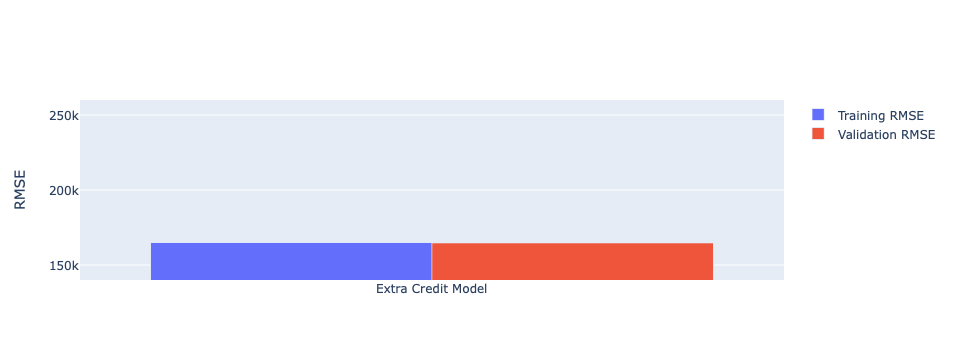

In [183]:
# Optional: Run this cell to visualize

#import plotly.graph_objects as go

fig = go.Figure([
go.Bar(x = ["Extra Credit Model"], y = [training_error_ec], name="Training RMSE"),
go.Bar(x = ["Extra Credit Model"], y = [validation_error_ec], name="Validation RMSE"),

])


fig
fig.update_yaxes(range=[140000,260000], title="RMSE")
# Feel free to update the range as needed

Text(0.5, 1.0, 'EC Val Data: Residuals vs. Log(Sale Price)')

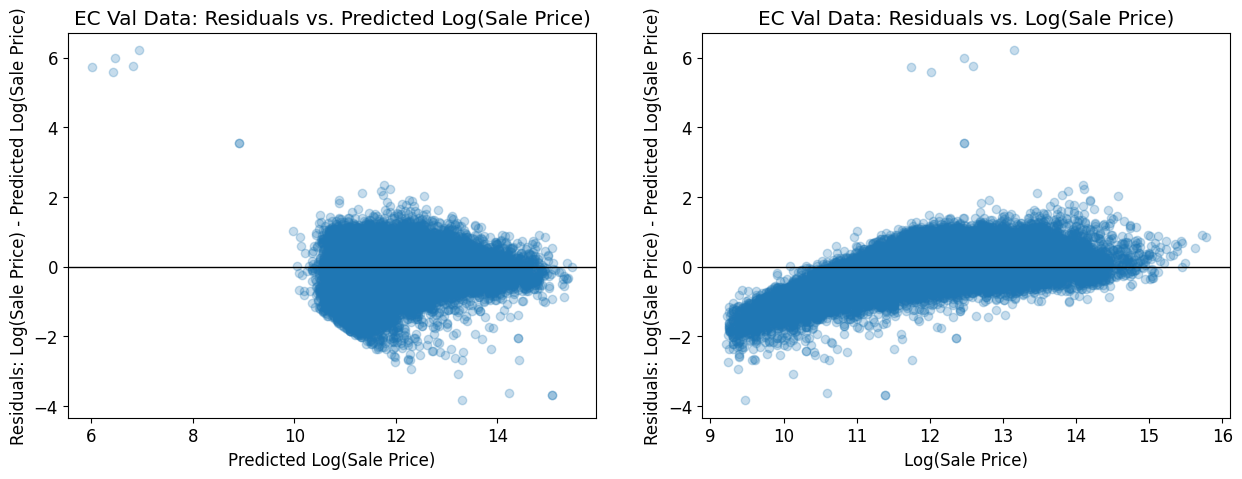

In [177]:
# MODELING STEP 5: Plot 2 side-by-side residual plots for validation data

fig, ax = plt.subplots(1,2, figsize=(15, 5))

residuals = y_valid_ec - y_predict_valid_ec

x_plt1 = y_predict_valid_ec
y_plt1 = residuals

x_plt2 = y_valid_ec
y_plt2 = residuals


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("EC Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("EC Val Data: Residuals vs. Log(Sale Price)")


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Extra Credit Step 2:  Explanation (Required for points on model above):

 - Explain what you did to create your model.  What versions did you try?  What worked and what didn't? 

 - Comment on the RMSE and residual plots from your model.   Are the residuals of your model still showing a trend that overestimates lower priced houses and underestimates higher priced houses?

**Write your answers in the text cell below**


I had played around a lot with different columns, such as Estimate(Land), Neighborhood Code, and Age Decade; however, those features didn't have a strong effect on the total RMSE. So, I just removed them and continued to add on other columns until I noticed noticeable changes. For instance, what really decreased my RMSE were property class and town codes, as once I one hot encoded and implemented them into my model, I noticed a significant decrease in the total compared to when I used the other previously mentioned features. The RMSE and residual plots definitely appear to be more significant than the ones from the previous models as well. There is still a slight trend seen in the graphs, but the dispersion is getting closer to being around 0 compared to before.

<!-- END QUESTION -->

## Extra Credit Step 3: Create and Submit Test Set Predictions to Gradescope

Now it's time to test your model on the actual test set.  You are only allowed to submit to Gradescope once, so wait until you have the best version of your model.    

The test data is in the dataframe `test_data`.  

Process the test data and run it through your model. Store your predictions from the test_data in the variable `y_test_pred`.  These should be in units Log Sale Price (you do not need to exponentiate them).  

Then run the cell provided below to create a .csv file to store your predictions on the test set and submit this .csv to the Gradescope Assignment: **"Project 2 Extra Credit Test Predictions"**. 
Note that **you will not receive credit for the test set predictions (i.e. up to 10 points) unless you submit your.csv to the Gradescope assignment**!


In [178]:
# Cells to process the test_data and run the model on it.  
# You CAN add any additional cells below
# Note: Make sure you don't remove any of the rows from the test data set.

processed_test_ec = process_data_ec(test_data, dataset_type = 3) 


y_test_pred = linear_model_ec.predict(processed_test_ec)

KeyError: 'Sale Price'

In [94]:
# Run this cell to make sure that your values are in log(Sale Price) and not Sale Price
assert (y_test_pred.max())< 25

NameError: name 'y_test_pred' is not defined

In [77]:
# Run this cell to make sure you did not drop any of the rows in the original test dataset
assert len(y_test_pred) == 55311

NameError: name 'y_test_pred' is not defined

In [ ]:
# Run this file to create the .csv of your predictions for the test set to upload to the assignment in Gradescope labeled Project 2 Extra Credit Test Predictions to have it checked.


#Store your predictions for the test set in Y_test_pred 
#(these should be in units of Log Sale Price)


# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": pd.read_csv('cook_county_contest_test.csv')['Unnamed: 0'], 
    "Value": y_test_pred,
}, columns=['Id', 'Value'])
submission_df.to_csv("submission.csv", index=False)

print('Created a CSV file:')
print('You MUST now upload this CSV file to the Gradescope assignment "Project 2 Extra Credit Test Predictions" for scoring.')

## Congratulations! You have finished the Project - Part 2


If you discussed this assignment with any other students in the class (in a manner that is acceptable as described by the Collaboration policy above) please **include their names** here:

**Collaborators**: *list collaborators here*

### Submission Instructions

Before proceeding any further, **save this notebook.**

After running the `grader.export()` cell provided below, **2 files will be created**: a zip file and pdf file.  You can download them using the links provided below OR by finding them in the same folder where this juptyer notebook resides in your JuptyerHub.

To receive credit on this assignment, **you must submit BOTH of these files
to their respective Gradescope portals:** 

* **Project Part 2 Autograded**: Submit the zip file that is output by the `grader.export()` cell below to the Autograded assignment in Gradescope.

* **Project Part 2 Manually Graded**: Submit your ProjectPart2.PDF to the  Manually Graded assignment in Gradescope.  **YOU MUST SELECT THE PAGES CORRESPONDING TO EACH QUESTION WHEN YOU UPLOAD TO GRADESCOPE.  IF NOT, YOU WILL LOSE POINTS**   Also, **check** that all of your plots **and** all lines of your code are showing up in your PDF before submitting.  If not, you will not receive credit for your plots/code.  

* **Extra Credit Submission**:  If you completed the extra credit, to receive credit for the Test Case prediction you must submit your Test Case prediction.csv (generated in the last cell of the extra credit section) to the Gradescope assignment titled "Project 2 Extra Credit Test Predictions"

**You are responsible for ensuring your submission follows our requirements. We will not be granting regrade requests nor extensions to submissions that don't follow instructions.** If you encounter any difficulties with submission, please don't hesitate to reach out to staff prior to the deadline.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

AFTER running the cell below, click on <a href='ProjPart2.pdf' download>this link to download the PDF </a> to upload to Gradescope.  There will be a separate link that appears after running the cell below with a link to download the zip file to upload to Gradescope.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)